# This notebook performs the iterative estimation of 2508.21131 assuming no frequency correlations and frequency and angular structure to factorize

### - Start importing all libraries

In [ ]:
# Global imports
import sys
import tqdm
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA import get_tensors as gt
from fastPTA import utils as ut
from fastPTA.data import generate_data as gd
from fastPTA.angular_decomposition import spherical_harmonics as sph
from fastPTA.data import data_correlations as dc
from fastPTA.inference_tools import iterative_estimation as ie

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

### - Define some constants

In [2]:
# Number of frequency bins to use in the analysis
nfreqs = 10

# Time span of the observation
Tspan_yrs = 16.0

# Time span in seconds
Tspan = Tspan_yrs * ut.yr

# Number of pulsars to simulate
npulsars = 50

### - Define the frequency vector and the spectral shape

In [3]:
# Frequency vector
fi = jnp.arange(1, nfreqs + 1) / Tspan

# Spectrum
S_f = (fi / ut.f_yr) ** -5

### - Choose the pixelization of the sky, l_max

In [4]:
Nside = 8
l_max = 3

n_params = sph.get_n_coefficients_real(l_max)

### - Define the injection and get the theoretical sky map 

In [5]:
# Initialize the real C_lm coefficients
clms_real = np.zeros(n_params)

# Add the monopole (with the right normalization)
clms_real[0] = 1 / np.sqrt(4 * np.pi)

# Add a dipole (optional)
clms_real[2] = 1 / np.sqrt(4 * np.pi) / np.sqrt(3)

# Get the map from the real C_lm coefficients
Pk = sph.get_map_from_real_clms(clms_real, Nside, l_max=l_max)

# Full spectrum (external frequency \times angular structure)
H_p_f = Pk[:, None] * S_f[None, :]

### - Generate random pulsar positions and distances

In [6]:
# Generate pulsar sky positions and distances
p_vec, cos_IJ, distances, theta_k, phi_k = gd.generate_pulsar_sky_and_kpixels(
    npulsars, Nside
)

# Convert distance from pc to meters
distances *= ut.parsec

# Compute Hellings-Downs correlations
HD_IJ = gt.HD_correlations(cos_IJ)

### - Compute the gamma_IJ_lm

In [7]:
gamma_IJ_lm = gt.get_correlations_lm_IJ(p_vec, l_max, Nside)

### - Run the iterative estimate several times

In [8]:
# Choose the number of runs to perform
N_runs = 300

# Initialize arrays to hold the means and standard deviations
means = np.zeros((N_runs, n_params))
stds = np.zeros((N_runs, n_params))

# Initial guess (quite far away from the true values)
full_guess = np.zeros(n_params)
full_guess[0] = np.sqrt(4 * np.pi)
full_guess *= 10

# Perform the runs in a for loop
for nn in tqdm.tqdm(range(N_runs)):

    # Generate a random realization of the GWB
    h_tilde = gd.generate_hpc_polarization_pixel_frequency(H_p_f)

    # Compute the data correlation D_IJ
    D_IJ = dc.get_D_IJ_fi(
        Tspan,
        fi,
        fi,
        h_tilde,
        distances,
        p_vec,
        theta_k,
        phi_k,
    )

    # Get the estimated values for the parameters
    theta, uncertainties, _ = ie.iterative_estimation(
        ie.get_update_estimate_diagonal, full_guess, D_IJ, gamma_IJ_lm, fi, S_f
    )

    # Update the corresponding mean and std
    means[nn] = theta
    stds[nn] = uncertainties

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:19<00:00,  3.78it/s]


### - Filter nans (we can get some in the minimization if the uncertainties are too large)

In [9]:
means = means[~np.isnan(stds).any(axis=1)]
stds = stds[~np.isnan(stds).any(axis=1)]
stds = stds[~np.isnan(means).any(axis=1)]
means = means[~np.isnan(means).any(axis=1)]

### - Plot the histograms for all our runs and compare with a gaussian distribution

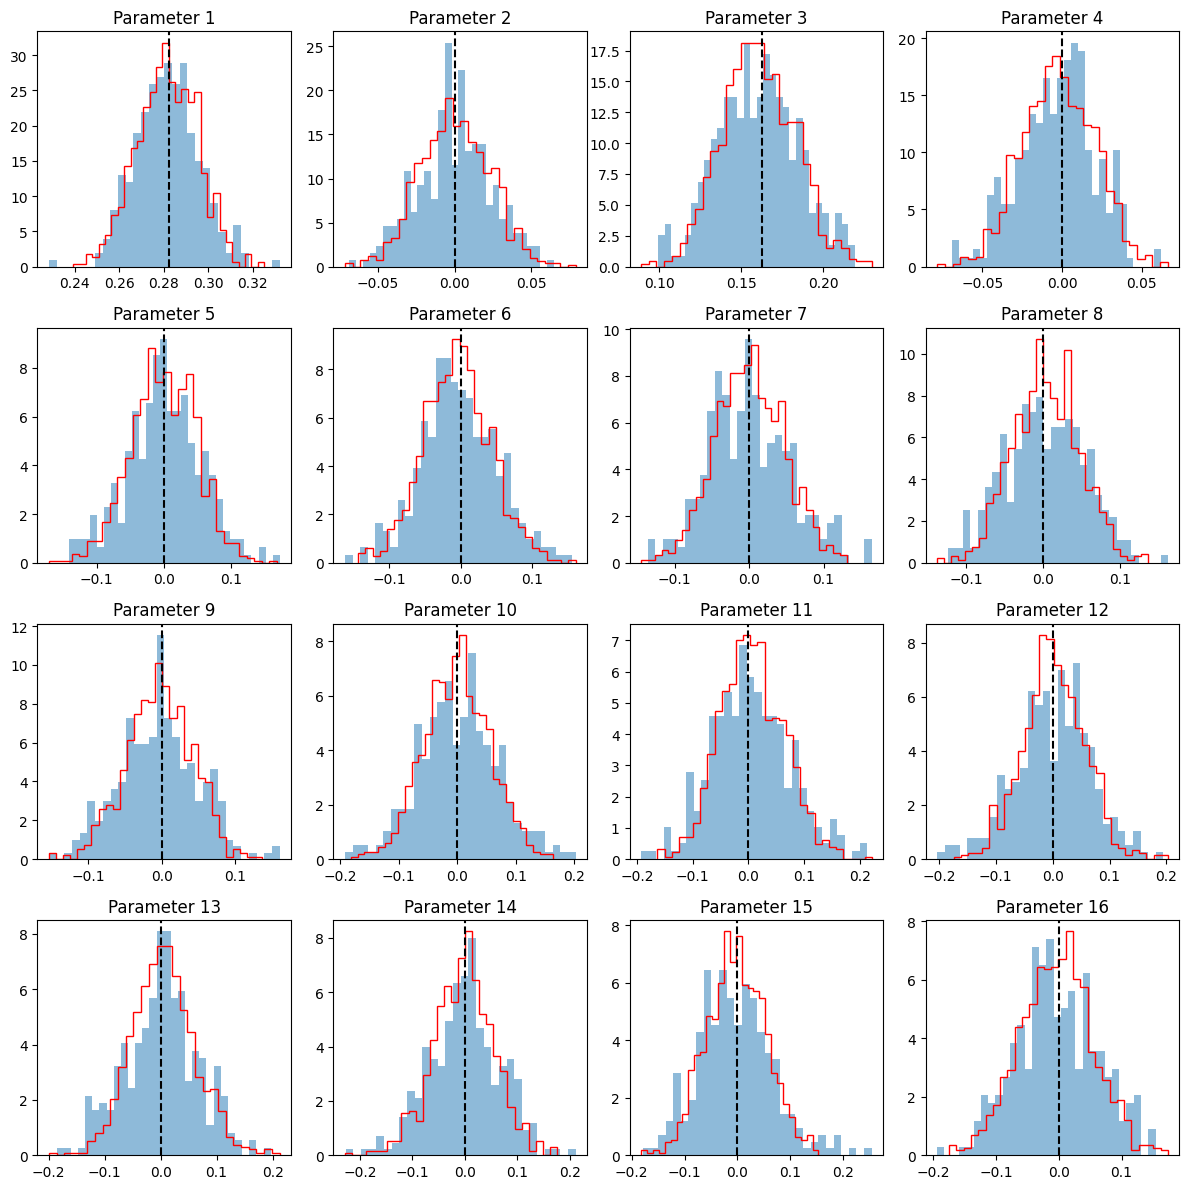

In [10]:
nplots = sph.get_n_coefficients_real(l_max)
ncols = 4
n_bins = 30


fig, ax = plt.subplots(ncols=ncols, nrows=int(nplots / ncols), figsize=(12, 12))


for i in range(nplots):
    # Plot the histogram of the means
    ax[int(i / 4), i % 4].hist(
        means[:, i], bins=n_bins, density=True, alpha=0.5
    )

    # Generate Gaussian random data with
    # mean = mean of the means
    # std = mean of stds
    gauss = np.random.normal(np.mean(means[:, i]), np.mean(stds[:, i]), (1000))

    # Plot the histogram of the Gaussian random data
    ax[int(i / 4), i % 4].hist(
        gauss, bins=n_bins, density=True, histtype="step", color="red"
    )

    # Plot the true value
    ax[int(i / 4), i % 4].axvline(
        clms_real[i], color="black", linestyle="dashed"
    )

    ax[int(i / 4), i % 4].set_title(f"Parameter {i + 1}")

plt.tight_layout()

### - As above but subtracting the mean and rescaling by the std

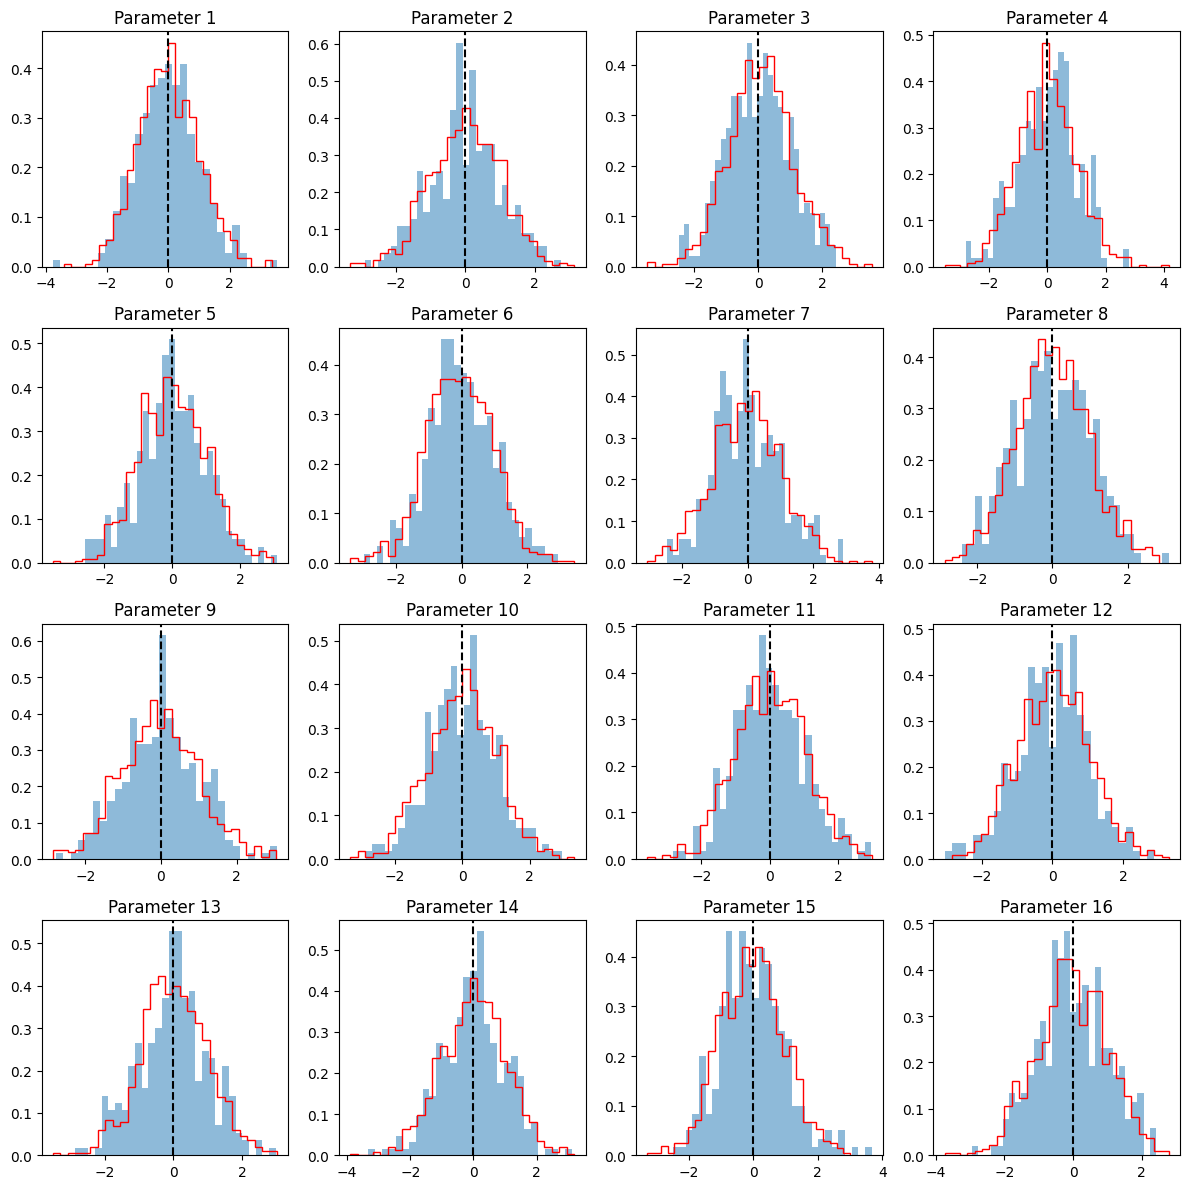

In [11]:
nplots = sph.get_n_coefficients_real(l_max)
ncols = 4
n_bins = 30


fig, ax = plt.subplots(ncols=ncols, nrows=int(nplots / ncols), figsize=(12, 12))


for i in range(nplots):
    mmean = np.mean(means[:, i])
    mstd = np.std(means[:, i])

    # Plot the histogram of the means (standardized)
    ax[int(i / 4), i % 4].hist(
        (means[:, i] - mmean) / mstd, bins=n_bins, density=True, alpha=0.5
    )

    # Standardized Gaussian random data
    gauss = np.random.normal(0, 1, 1000)

    # Plot the histogram of the standardized Gaussian random data
    ax[int(i / 4), i % 4].hist(
        gauss, bins=n_bins, density=True, histtype="step", color="red"
    )

    # Plot the true value
    ax[int(i / 4), i % 4].axvline(0, color="black", linestyle="dashed")

    ax[int(i / 4), i % 4].set_title(f"Parameter {i + 1}")

plt.tight_layout()

### - Get the CLs and their uncertainties

In [12]:
# Compute the angular power spectrum
CL = sph.get_CL_from_real_clm(means.T)

# Compute the uncertainty on the angular power spectrum
dCL = sph.get_dCL_from_real_clm(means.T, stds.T)

### - Plot the distribution of the CLs

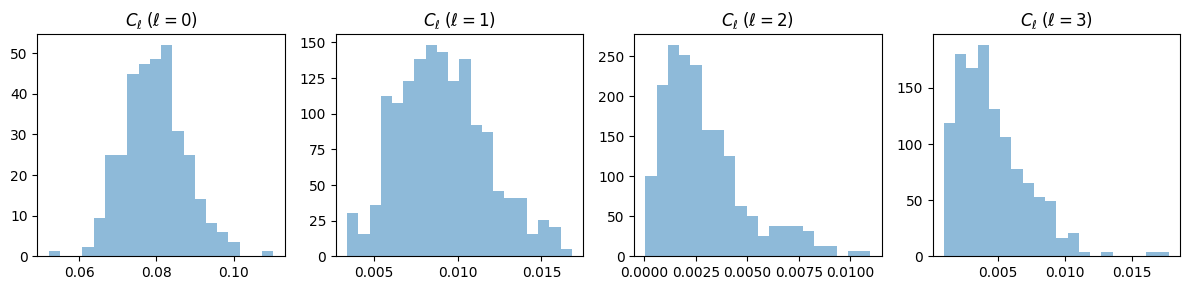

In [13]:
nbins = 20
fig, ax = plt.subplots(ncols=l_max + 1, figsize=(12, 3))

for i in range(0, l_max + 1):
    ax[i].hist(CL[i], bins=nbins, density=True, alpha=0.5)
    ax[i].set_title(r"$C_{\ell} \; (\ell = " + str(i) + ")$")
plt.tight_layout()

### - Plot the distribution of the CLs rescaled by the uncertainties

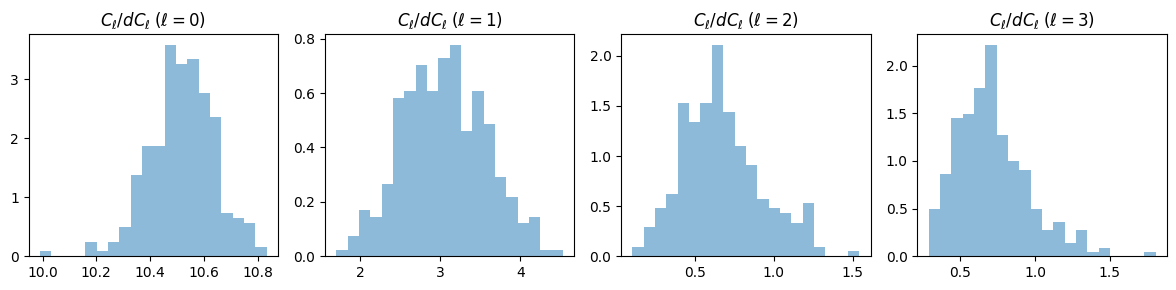

In [14]:
nbins = 20
fig, ax = plt.subplots(ncols=l_max + 1, figsize=(12, 3))

for i in range(0, l_max + 1):
    ax[i].hist(CL[i] / dCL[i], bins=nbins, density=True, alpha=0.5)
    ax[i].set_title(r"$C_{\ell} / dC_{\ell} \; (\ell = " + str(i) + ")$")
plt.tight_layout()